In [4]:
### Dependencies ----------------------------------------------------------------
import pandas as pd # used for working with data sets


###COMBINE ALL .CSVS INTO ONE
file_path = r"..\data\combined.csv"


data = pd.read_csv(file_path)

# Slovník číselníků
num_dict = {
    'Prague-outskirts': 1,
    'Prague-center': 2,
    'Prague': 3
}

# Nový sloupec 'neighb_num' v DataFrame
data['neighb_num'] = data['neighbourhood_cleansed'].map(num_dict)

data.head()


,date,price,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,instant_bookable,host_since_bins,bathrooms_num,bathrooms_shared_bool,neighb_num
0,2023-06-24,1396.0,4,1,1,1,0,1,0,Prague-center,...,3,1.0,2.0,2,5.0,0,1,1.5,0,2
1,2023-06-24,3998.0,2,0,1,0,0,1,0,Prague-center,...,3,1.0,2.0,0,NaN,1,1,1.0,0,2
2,2023-06-24,2555.0,3,0,1,0,0,1,0,Prague-center,...,3,1.0,2.0,10,4.3,1,1,1.0,0,2
3,2023-06-24,3998.0,2,0,1,0,0,1,0,Prague-center,...,3,1.0,2.0,0,NaN,1,1,1.0,0,2
4,2023-06-24,2555.0,3,0,1,0,0,1,0,Prague-center,...,3,1.0,2.0,1,5.0,1,1,1.0,0,2


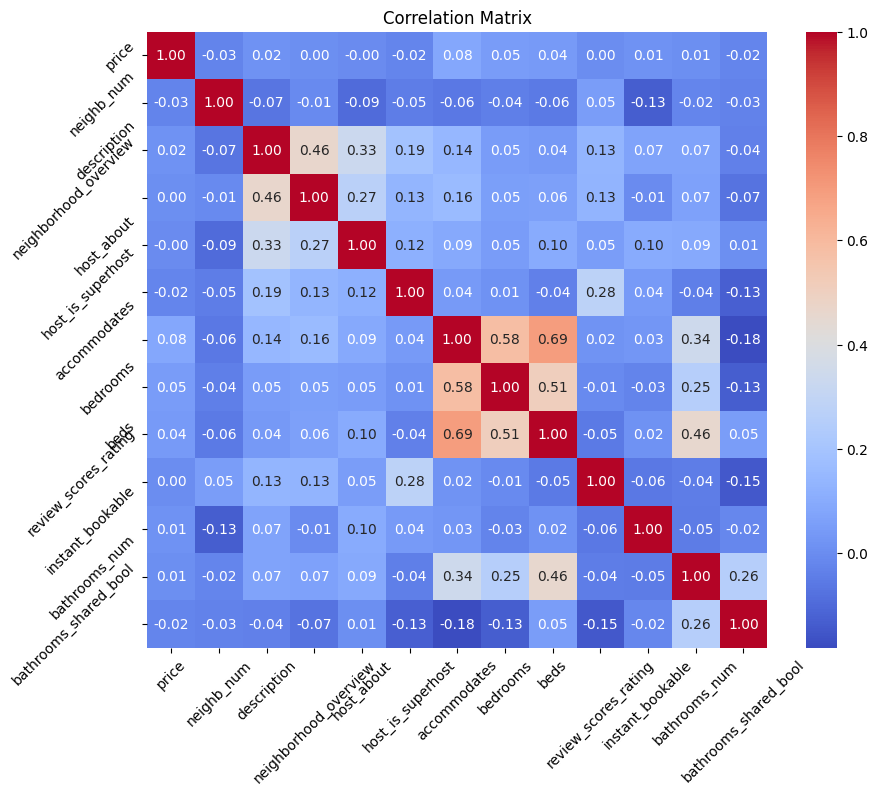

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = ['price', 'neighb_num','description', 'neighborhood_overview', 'host_about', 'host_is_superhost',
                   'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'instant_bookable',
                   'bathrooms_num', 'bathrooms_shared_bool']  

selected_data = data[selected_columns]

correlation_matrix = selected_data.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()


In [9]:
## dělba na datasety, ale nějak se to jebe, je to potřeba polatid, aby to fakt bylo správně podle toho data, chyba je nejspíš v tom postupu toho train test splitu...

from sklearn.model_selection import train_test_split

# Převedení sloupce 'date' na datový typ datetime
data['date'] = pd.to_datetime(data['date'])

# Seřazení dat podle data
data_sorted = data.sort_values(by='date')

# Rozdělení dat na trénovací, validační a testovací množiny
train_data, test_valid_data = train_test_split(data_sorted, test_size=0.4, shuffle=False)
valid_data, test_data = train_test_split(test_valid_data, test_size=0.5, shuffle=False)

# Uložení jednotlivých množin do DataFrame
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)
test_df = pd.DataFrame(test_data)


In [10]:
# Kontrola výsledků
print("Trénovací data:")
print(train_df.head())
print("\nValidační data:")
print(valid_df.head())
print("\nTestovací data:")
print(test_df.head())


Trénovací data:
           date    price  description  neighborhood_overview  host_since  \
0    2023-06-24   1396.0            4                      1           1   
5626 2023-06-24   3570.0            3                      0           1   
5625 2023-06-24   1395.0            4                      0           1   
5624 2023-06-24   1395.0            4                      0           1   
5623 2023-06-24  10466.0            4                      0           1   

      host_about  host_is_superhost  host_has_profile_pic  \
0              1                  0                     1   
5626           1                  1                     1   
5625           0                  0                     1   
5624           0                  0                     1   
5623           0                  0                     1   

      host_identity_verified neighbourhood_cleansed  ... accommodates  \
0                          0          Prague-center  ...            3   
5626          